# EB5002 Text Processing

# Base Models

Code adapted from <https://www.kaggle.com/alvations/gru-language-model>

## Set the working directory

In [1]:
import os
os.chdir(os.path.join(os.path.sep, 'home', 'tkokkeng', 'Documents', 'EB5002-TextProcessing'))
os.getcwd()

'/home/tkokkeng/Documents/EB5002-TextProcessing'

In [2]:
import sys
if os.path.join(os.getcwd(), 'source') not in sys.path:
    sys.path.append(os.path.join(os.getcwd(), 'source'))
sys.path

['/home/tkokkeng/python/python367/ptvenv/lib/python36.zip',
 '/home/tkokkeng/python/python367/ptvenv/lib/python3.6',
 '/home/tkokkeng/python/python367/ptvenv/lib/python3.6/lib-dynload',
 '/usr/lib/python3.6',
 '',
 '/home/tkokkeng/python/python367/ptvenv/lib/python3.6/site-packages',
 '/home/tkokkeng/.local/lib/python3.6/site-packages',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/home/tkokkeng/.local/lib/python3.6/site-packages/IPython/extensions',
 '/home/tkokkeng/.ipython',
 '/home/tkokkeng/Documents/EB5002-TextProcessing/source']

In [3]:
# IPython candies...
from IPython.display import Image
from IPython.core.display import HTML
from IPython.display import clear_output

In [4]:
from collections import namedtuple
import numpy as np
from tqdm import tqdm
import json
import io
import math
import pickle
import shutil
import datetime

from gensim.corpora import Dictionary

import torch
from torch import nn, optim, tensor, autograd
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(12, 8)})

torch.manual_seed(42)

## Load data

In [6]:
# Tokenize the text.
# tokenized_text = [list(map(str.lower, word_tokenize(sent))) 
#                   for sent in sent_tokenize(text)]

with io.open(os.path.join('data', 'final', 'all_books_8975.txt'), encoding='utf8') as infile:
    tokenized_text = json.load(infile)

In [7]:
len(tokenized_text)

8975

In [8]:
tokenized_text[0]

['under',
 'none',
 'of',
 'the',
 'accredited',
 'ghostly',
 'circumstances',
 ',',
 'and',
 'environed',
 'by',
 'none',
 'of',
 'the',
 'conventional',
 'ghostly',
 'surroundings',
 ',',
 'did',
 'i',
 'first',
 'make',
 'acquaintance',
 'with',
 'the',
 'house',
 'which',
 'is',
 'the',
 'subject',
 'of',
 'this',
 'christmas',
 'piece',
 '.']

In [9]:
max([ len(i) for i in tokenized_text ])

407

Text(0, 0.5, 'Frequency')

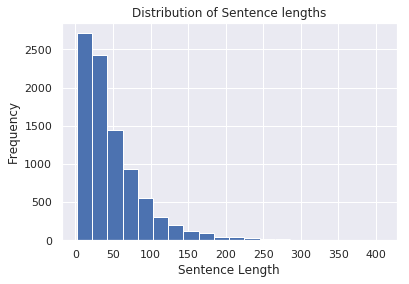

In [10]:
plt.hist([ len(i) for i in tokenized_text ], bins=20)
plt.title('Distribution of Sentence lengths')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')

In [11]:
sum(j > 100 for j in [ len(i) for i in tokenized_text ])

962

In [12]:
tokenized_text = list(map(lambda x: x[:100], tokenized_text))
max([ len(i) for i in tokenized_text ])

100

In [13]:
[ tokenized_text.index(i) for i in tokenized_text if len(i) == 100 ][0]

6

In [14]:
tokenized_text[6]

['i',
 'had',
 'got',
 'into',
 'the',
 'train',
 'at',
 'midnight',
 ',',
 'and',
 'had',
 'fallen',
 'asleep',
 ',',
 'and',
 'had',
 'woke',
 'up',
 'and',
 'had',
 'sat',
 'looking',
 'out',
 'of',
 'window',
 'at',
 'the',
 'brilliant',
 'northern',
 'lights',
 'in',
 'the',
 'sky',
 ',',
 'and',
 'had',
 'fallen',
 'asleep',
 'again',
 ',',
 'and',
 'had',
 'woke',
 'up',
 'again',
 'to',
 'find',
 'the',
 'night',
 'gone',
 ',',
 'with',
 'the',
 'usual',
 'discontented',
 'conviction',
 'on',
 'me',
 'that',
 'i',
 'hadn',
 '’',
 't',
 'been',
 'to',
 'sleep',
 'at',
 'all',
 ';',
 '—',
 'upon',
 'which',
 'question',
 ',',
 'in',
 'the',
 'first',
 'imbecility',
 'of',
 'that',
 'condition',
 ',',
 'i',
 'am',
 'ashamed',
 'to',
 'believe',
 'that',
 'i',
 'would',
 'have',
 'done',
 'wager',
 'by',
 'battle',
 'with',
 'the',
 'man',
 'who',
 'sat']

## Divide data into train and validation splits

In [15]:
train_idx = np.random.choice(range(len(tokenized_text)), size=6000, replace=False)
train_idx

array([6796, 4139, 4946, ..., 8476, 2139,  585])

In [16]:
tokenized_text_train = [ tokenized_text[i] for i in train_idx ]

In [17]:
with io.open(os.path.join('tokenized_train.json'), 'w', encoding='utf8') as outfile:
    json.dump(tokenized_text_train, outfile, ensure_ascii=False)

In [18]:
val_idx = list(set(range(len(tokenized_text))) - set(train_idx))
tokenized_text_val = [ tokenized_text[i] for i in val_idx ]
with io.open(os.path.join('tokenized_val.json'), 'w', encoding='utf8') as outfile:
    json.dump(tokenized_text_val, outfile, ensure_ascii=False)

## Reload saved train and validation splits

In [19]:
with io.open(os.path.join('data', 'splits', 'tokenized_train_100.json'), encoding='utf8') as infile:
    tokenized_text_train = json.load(infile)
with io.open(os.path.join('data', 'splits', 'tokenized_val_100.json'), encoding='utf8') as infile:
    tokenized_text_val = json.load(infile)

In [20]:
print(len(tokenized_text_train), len(tokenized_text_val))

6000 2975


In [21]:
tokenized_text_train[0]

['there',
 'i',
 'stood',
 ',',
 'for',
 'minutes',
 ',',
 'looking',
 'at',
 'joe',
 ',',
 'already',
 'at',
 'work',
 'with',
 'a',
 'glow',
 'of',
 'health',
 'and',
 'strength',
 'upon',
 'his',
 'face',
 'that',
 'made',
 'it',
 'show',
 'as',
 'if',
 'the',
 'bright',
 'sun',
 'of',
 'the',
 'life',
 'in',
 'store',
 'for',
 'him',
 'were',
 'shining',
 'on',
 'it.',
 '“good-bye',
 ',',
 'dear',
 'joe',
 '!',
 '--',
 'no',
 ',',
 'don',
 '’',
 't',
 'wipe',
 'it',
 'off',
 '--',
 'for',
 'god',
 '’',
 's',
 'sake',
 ',',
 'give',
 'me',
 'your',
 'blackened',
 'hand',
 '!',
 '--',
 'i',
 'shall',
 'be',
 'down',
 'soon',
 'and',
 'often.',
 '”',
 '“never',
 'too',
 'soon',
 ',',
 'sir',
 ',',
 '”',
 'said',
 'joe',
 ',',
 '“and',
 'never',
 'too',
 'often',
 ',',
 'pip',
 '!',
 '”',
 'biddy',
 'was']

In [22]:
class BooksDataset(Dataset):
    def __init__(self, texts, vocab=None):
        self.texts = texts
        
        # Initialize the vocab 
        special_tokens = {'<pad>': 0, '<unk>':1, '<s>':2, '</s>':3}
        if vocab:
            self.vocab=vocab
        else:
            self.vocab = Dictionary(texts)
        self.vocab.patch_with_special_tokens(special_tokens)
        
        # Keep track of the vocab size.
        self.vocab_size = len(self.vocab)
        
        # Keep track of how many data points.
        self._len = len(texts)
        
        # Find the longest text in the data.
        self.max_len = max(len(txt) for txt in texts) 
        
    def __getitem__(self, index):
        vectorized_sent = self.vectorize(self.texts[index])
        x_len = len(vectorized_sent)
        # To pad the sentence:
        # Pad left = 0; Pad right = max_len - len of sent.
        pad_dim = (0, self.max_len - len(vectorized_sent))
        vectorized_sent = F.pad(vectorized_sent, pad_dim, 'constant')
        return {'x':vectorized_sent[:-1], 
                'y':vectorized_sent[1:], 
                'x_len':x_len}
    
    def __len__(self):
        return self._len
    
    def vectorize(self, tokens, start_idx=2, end_idx=3):
        """
        :param tokens: Tokens that should be vectorized. 
        :type tokens: list(str)
        """
        # See https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.doc2idx 
        # Lets just cast list of indices into torch tensors directly =)
        
        vectorized_sent = [start_idx] + self.vocab.doc2idx(tokens, 1) + [end_idx]
        return torch.tensor(vectorized_sent)
    
    def unvectorize(self, indices):
        """
        :param indices: Converts the indices back to tokens.
        :type tokens: list(int)
        """
        return [self.vocab[i] for i in indices]

In [23]:
books_data_train = BooksDataset(tokenized_text_train)
len(books_data_train.vocab)

16326

In [24]:
tokenized_text_train[0]

['there',
 'i',
 'stood',
 ',',
 'for',
 'minutes',
 ',',
 'looking',
 'at',
 'joe',
 ',',
 'already',
 'at',
 'work',
 'with',
 'a',
 'glow',
 'of',
 'health',
 'and',
 'strength',
 'upon',
 'his',
 'face',
 'that',
 'made',
 'it',
 'show',
 'as',
 'if',
 'the',
 'bright',
 'sun',
 'of',
 'the',
 'life',
 'in',
 'store',
 'for',
 'him',
 'were',
 'shining',
 'on',
 'it.',
 '“good-bye',
 ',',
 'dear',
 'joe',
 '!',
 '--',
 'no',
 ',',
 'don',
 '’',
 't',
 'wipe',
 'it',
 'off',
 '--',
 'for',
 'god',
 '’',
 's',
 'sake',
 ',',
 'give',
 'me',
 'your',
 'blackened',
 'hand',
 '!',
 '--',
 'i',
 'shall',
 'be',
 'down',
 'soon',
 'and',
 'often.',
 '”',
 '“never',
 'too',
 'soon',
 ',',
 'sir',
 ',',
 '”',
 'said',
 'joe',
 ',',
 '“and',
 'never',
 'too',
 'often',
 ',',
 'pip',
 '!',
 '”',
 'biddy',
 'was']

In [25]:
books_data_train.vectorize(tokenized_text_train[0])

tensor([    2,    58,    24,    51, 16323,    16,    34, 16323,    31,     7,
           29, 16323,     4,     7,    65,    64, 16325,    18,    37,    21,
            5,    53,    60,    23,    15,    56,    32,    27,    48,     6,
           25,    57,    11,    54,    37,    57,    30,    26,    52,    16,
           22,    62,    47,    41,    28,    69, 16323,    12,    29, 16322,
        16324,    36, 16323,    13,    67,    55,    63,    27,    38, 16324,
           16,    19,    67,    43,    45, 16323,    17,    33,    66,    10,
           20, 16322, 16324,    24,    46,     8,    14,    50,     5,    40,
           71,    70,    59,    50, 16323,    49, 16323,    71,    44,    29,
        16323,    68,    35,    59,    39, 16323,    42, 16322,    71,     9,
           61,     3])

In [26]:
books_data_train.vocab.token2id['free']

384

In [27]:
[ books_data_train.vocab[i] for i in range(20) ]

['<pad>',
 '<unk>',
 '<s>',
 '</s>',
 'already',
 'and',
 'as',
 'at',
 'be',
 'biddy',
 'blackened',
 'bright',
 'dear',
 'don',
 'down',
 'face',
 'for',
 'give',
 'glow',
 'god']

In [28]:
books_data_train.vocab.filter_extremes(no_below=0, no_above=1, keep_n=5000, keep_tokens=['<pad>', '<unk>', '<s>', '</s>'])
len(books_data_train.vocab)

5000

In [29]:
[ books_data_train.vocab[i] for i in range(20) ]

['<pad>',
 '<unk>',
 '<s>',
 '</s>',
 'already',
 'and',
 'as',
 'at',
 'be',
 'biddy',
 'blackened',
 'bright',
 'dear',
 'don',
 'down',
 'face',
 'for',
 'give',
 'glow',
 'god']

In [30]:
books_data_train.vectorize(tokenized_text_train[0])

tensor([ 2, 57, 24, 50,  1, 16, 34,  1, 31,  7, 29,  1,  4,  7, 64, 63,  1, 18,
        37, 21,  5, 52, 59, 23, 15, 55, 32, 27, 47,  6, 25, 56, 11, 53, 37, 56,
        30, 26, 51, 16, 22, 61, 46, 40, 28, 68,  1, 12, 29,  1,  1, 36,  1, 13,
        66, 54, 62, 27, 38,  1, 16, 19, 66, 42, 44,  1, 17, 33, 65, 10, 20,  1,
         1, 24, 45,  8, 14, 49,  5,  1, 70, 69, 58, 49,  1, 48,  1, 70, 43, 29,
         1, 67, 35, 58, 39,  1, 41,  1, 70,  9, 60,  3])

In [31]:
books_data_val = BooksDataset(tokenized_text_val, books_data_train.vocab)
len(books_data_val.vocab)

5000

In [32]:
batch_size = 128
dataloader = DataLoader(dataset=books_data_val, batch_size=batch_size, shuffle=True)

for data_dict in dataloader:
    print(data_dict['x_len'])
    break

tensor([ 27,  53,  41,  65,  99,  60, 102,  13,  28,  10,  65,  11,  18,  69,
         88,  34,  35,  44,  11,  14,  29,  34,  52,  12,  43,  31,  36,  67,
         31,  32,  30,  13,  51,  30,  58,  61,  68,  23,  21,  18,  62, 102,
         36,  34, 102,  24, 102,  26,  59,  78,  33,  10,   8, 102,  15, 102,
         20,  71,  96,  88,   8,  87,  14,  18,  34,  40,  74,  23,  26,  33,
         34,  60,  71,  71,  69, 102,  10,  26,  63, 102,  32,  90,  15,   7,
         61,  38,   9,  84,  54,  67,  28,  14, 102,  57,  92,  84,  33,  56,
         87,  10,  66,  41,  23,  83,  33,  93,  35,  34,  14,  41,  48,  91,
         10,  22,  19,  33,  70,  88, 102,  87,  45,  68, 102,  34,  38,  33,
         54,  58])


In [33]:
batch_size = 128
dataloader = DataLoader(dataset=books_data_val, batch_size=batch_size, shuffle=True)

for data_dict in dataloader:
    # Sort indices of data in batch by lengths.
    sorted_indices = np.array(data_dict['x_len']).argsort()[::-1].tolist()
    data_batch = {name:_tensor[sorted_indices]
                  for name, _tensor in data_dict.items()}
    print(data_batch)
    break

{'x': tensor([[   2,  201,    1,  ..., 2437,   33,  115],
        [   2,    5,   57,  ...,  361,  333,    1],
        [   2,  306,    1,  ...,   87,  157,  324],
        ...,
        [   2,  293,   33,  ...,    0,    0,    0],
        [   2,   24,  139,  ...,    0,    0,    0],
        [   2,   24,    1,  ...,    0,    0,    0]]), 'y': tensor([[ 201,    1,  308,  ...,   33,  115,  374],
        [   5,   57,   60,  ...,  333,    1,   24],
        [ 306,    1, 2891,  ...,  157,  324,   70],
        ...,
        [ 293,   33,  141,  ...,    0,    0,    0],
        [  24,  139,  118,  ...,    0,    0,    0],
        [  24,    1,  118,  ...,    0,    0,    0]]), 'x_len': tensor([102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102,
        102, 102, 102, 102, 102, 102, 101,  96,  93,  91,  90,  88,  86,  86,
         82,  82,  80,  76,  74,  71,  68,  67,  67,  67,  64,  61,  60,  59,
         59,  58,  58,  57,  57,  56,  56,  55,  55,  54,  53,  52,  52,  51,
         50,  

## Model

In [34]:
class Generator(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, num_layers, dropout=0, recurrent_dropout=0):
        super(Generator, self).__init__()

        # Initialize the embedding layer with the 
        # - size of input (i.e. no. of words in input vocab)
        # - no. of hidden nodes in the embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        
        # Initialize the GRU with the 
        # - size of the input (i.e. embedding layer)
        # - size of the hidden layer 
        self.gru = nn.GRU(embedding_size, hidden_size, num_layers, batch_first=True, dropout=recurrent_dropout)
        
        # Initialize the "classifier" layer to map the RNN outputs
        # to the vocabulary. Remember we need to -1 because the 
        # vectorized sentence we left out one token for both x and y:
        # - size of hidden_size of the GRU output.
        # - size of vocabulary
        self.classifier = nn.Linear(hidden_size, vocab_size)
        
        self.dropout = dropout
        
    def forward(self, inputs, use_softmax=False, hidden=None):
        # Look up for the embeddings for the input word indices.
        embedded = self.embedding(inputs)
        # Put the embedded inputs into the GRU.
        output, hidden = self.gru(embedded, hidden)
        
        # Matrix manipulation magic.
        batch_size, sequence_len, hidden_size = output.shape
        # Technically, linear layer takes a 2-D matrix as input, so more manipulation...
        output = output.contiguous().view(batch_size * sequence_len, hidden_size)
        # Apply dropout.
        if self.dropout:
            output = F.dropout(output, self.dropout)
        # output = F.dropout(output, 0.5)
        # Put it through the classifier
        # And reshape it to [batch_size x sequence_len x vocab_size]
        output = self.classifier(output).view(batch_size, sequence_len, -1)
        
        return (F.softmax(output,dim=2), hidden) if use_softmax else (output, hidden)

In [35]:
# Set the hidden_size of the GRU 
embed_size = 12
hidden_size = 10
num_layers = 1

_encoder = Generator(len(books_data_train.vocab), embed_size, hidden_size, num_layers)

In [36]:
# Take a batch.
batch_size = 128
traindataloader = DataLoader(dataset=books_data_train, batch_size=batch_size, shuffle=True)

_batch = next(iter(traindataloader))
_inputs, _lengths = _batch['x'], _batch['x_len']
_targets = _batch['y']

In [37]:
_inputs[0]

tensor([  2, 242, 329, 659,   1,   1, 140, 139,  16,   1, 154, 588,  26,   1,
         56, 658,  37, 657,   1, 133, 242,   7, 176, 660, 662,  26,  56, 652,
         37, 656,   1, 140, 139,   1, 110,   1,   5, 139,   1, 140, 574, 255,
        661, 382, 655, 654,   1, 202,  26,  56,   1,  37,  23,   1,   1, 653,
         56, 136,  37,  23,   1,   1, 115, 663,  23, 441,   1,  60, 350, 118,
          3,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0])

In [38]:
_targets[0]

tensor([242, 329, 659,   1,   1, 140, 139,  16,   1, 154, 588,  26,   1,  56,
        658,  37, 657,   1, 133, 242,   7, 176, 660, 662,  26,  56, 652,  37,
        656,   1, 140, 139,   1, 110,   1,   5, 139,   1, 140, 574, 255, 661,
        382, 655, 654,   1, 202,  26,  56,   1,  37,  23,   1,   1, 653,  56,
        136,  37,  23,   1,   1, 115, 663,  23, 441,   1,  60, 350, 118,   3,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0])

In [39]:
_output, _hidden = _encoder(_inputs)
print('Output sizes:\t', _output.shape)
print('Input sizes:\t', batch_size, books_data_train.max_len -1, len(books_data_train.vocab))
print('Target sizes:\t', _targets.shape)

Output sizes:	 torch.Size([128, 99, 5000])
Input sizes:	 128 99 5000
Target sizes:	 torch.Size([128, 99])


In [40]:
_output.shape

torch.Size([128, 99, 5000])

In [41]:
_output[-1].shape

torch.Size([99, 5000])

In [42]:
_, predicted_indices = torch.max(_output, dim=2)
print(predicted_indices.shape)


torch.Size([128, 99])


In [43]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

_hyper = ['vocab_size', 'embed_size', 'hidden_size', 'num_layers',
          'dropout', 'recurrent_dropout',
          'loss_func', 'learning_rate', 'optimizer', 'batch_size']
Hyperparams = namedtuple('Hyperparams', _hyper)


hyperparams = Hyperparams(vocab_size=None, embed_size=256, hidden_size=256, num_layers=1,
                          dropout=0.5, recurrent_dropout=0,
                          loss_func=nn.CrossEntropyLoss,
                          learning_rate=0.03, optimizer=optim.Adam, batch_size=128)

hyperparams

Hyperparams(vocab_size=None, embed_size=256, hidden_size=256, num_layers=1, dropout=0.5, recurrent_dropout=0, loss_func=<class 'torch.nn.modules.loss.CrossEntropyLoss'>, learning_rate=0.03, optimizer=<class 'torch.optim.adam.Adam'>, batch_size=128)

## Train model

In [44]:
def save_checkpoint(state, is_best, checkpoint):
   # Saves model and training parameters at checkpoint + 'last.pth.tar'. If is_best==True, also saves
   # checkpoint + 'best.pth.tar'
   # Args:
   #     state: (dict) contains model's state_dict, may contain other keys such as epoch, optimizer state_dict
   #     is_best: (bool) True if it is the best model seen till now
   #     checkpoint: (string) folder where parameters are to be saved

    filepath = os.path.join(checkpoint, 'last.pth')
    if not os.path.exists(checkpoint):
        # print("Checkpoint Directory does not exist! Making directory {}".format(checkpoint))
        os.mkdir(checkpoint)
    torch.save(state, filepath)
    if is_best:
        shutil.copyfile(filepath, os.path.join(checkpoint, 'best.pth'))

In [45]:
# Training routine.
def train(num_epochs, traindataloader, valdataloader, model, criterion, optimizer):
    losses = []
    val_losses = []
    best_val_loss = 0
    plt.ion()
    for _e in range(num_epochs):
        
        model.train(True)
        for batch in tqdm(traindataloader):
            # Zero gradient.
            optimizer.zero_grad()
            x = batch['x'].to(device)
            x_len = batch['x_len'].to(device)
            y = batch['y'].to(device)
            # Feed forward. 
            output, hidden = model(x, use_softmax=False)
            # Compute loss:
            # Shape of the `output` is [batch_size x sequence_len x vocab_size]
            # Shape of `y` is [batch_size x sequence_len]
            # CrossEntropyLoss expects `output` to be [batch_size x vocab_size x sequence_len]
            _, prediction = torch.max(output, dim=2)
            loss = criterion(output.permute(0, 2, 1), y)
            loss.backward()
            optimizer.step()
            losses.append(loss.float().data)

        clear_output(wait=True)
        # plt.plot(losses)
        # plt.pause(0.05)

        model.train(False)
        for batch in tqdm(valdataloader):
            # Zero gradient.
            optimizer.zero_grad()
            x = batch['x'].to(device)
            x_len = batch['x_len'].to(device)
            y = batch['y'].to(device)
            # Feed forward. 
            output, hidden = model(x, use_softmax=False)
            # Compute loss:
            # Shape of the `output` is [batch_size x sequence_len x vocab_size]
            # Shape of `y` is [batch_size x sequence_len]
            # CrossEntropyLoss expects `output` to be [batch_size x vocab_size x sequence_len]
            _, prediction = torch.max(output, dim=2)
            with torch.no_grad():
                val_loss = criterion(output.permute(0, 2, 1), y)
            # val_loss.backward()
            # optimizer.step()
            val_losses.append(val_loss.float().data)
            
            # Update best val_loss
            if not best_val_loss:
                best_val_loss = val_loss
            else:
                save_checkpoint(model.state_dict(), val_loss < best_val_loss, 'models')
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
        
        clear_output(wait=True)
        plt.figure(figsize=(10, 5))
        plt.subplot(121)
        plt.plot(losses, label='loss')
        plt.legend()
        plt.title('Training Loss')
        plt.subplot(122)
        plt.plot(val_losses, label='val_loss')
        plt.legend()
        plt.title('Validation Loss')
        plt.pause(0.05)
        
    return {'loss': losses, 'val_loss': val_losses}

def initialize_data_model_optim_loss(hyperparams):
    # Initialize the dataset and dataloader.
    with io.open(os.path.join('data', 'splits', 'tokenized_train_100.json'), encoding='utf8') as infile:
        tokenized_text_train = json.load(infile)
    with io.open(os.path.join('data', 'splits', 'tokenized_val_100.json'), encoding='utf8') as infile:
        tokenized_text_val = json.load(infile)
    books_data_train = BooksDataset(tokenized_text_train)
    books_data_train.vocab.filter_extremes(no_below=0, no_above=1, keep_n=hyperparams.vocab_size, keep_tokens=['<pad>', '<unk>', '<s>', '</s>'])
    books_data_val = BooksDataset(tokenized_text_val, books_data_train.vocab)
    traindataloader = DataLoader(dataset=books_data_train,
                                 batch_size=hyperparams.batch_size,
                                 shuffle=True)
    valdataloader = DataLoader(dataset=books_data_val,
                               batch_size=hyperparams.batch_size,
                               shuffle=True)

    # Loss function.
    criterion = hyperparams.loss_func(ignore_index=books_data_train.vocab.token2id['<pad>'], 
                                      reduction='mean')

    # Model.
    model = Generator(len(books_data_train.vocab), hyperparams.embed_size, 
                      hyperparams.hidden_size, hyperparams.num_layers,
                      hyperparams.dropout, hyperparams.recurrent_dropout).to(device)

    # Optimizer.
    optimizer = hyperparams.optimizer(model.parameters(), lr=hyperparams.learning_rate)
    
    return traindataloader, valdataloader, model, optimizer, criterion

In [46]:
def generate_example(model, temperature=1.0, max_len=100, hidden_state=None):
    start_token, start_idx = '<s>', 2
    # Start state.
    inputs = torch.tensor(books_data_train.vocab.token2id[start_token]).unsqueeze(0).unsqueeze(0).to(device)

    sentence = [start_token]
    i = 0
    
    # Built a complete sentence by iteratively feeding a partial sentence until </s> <pad> is generated or maxlen 
    while i < max_len and sentence[-1] not in ['</s>', '<pad>']:
        i += 1
        
        # Apply embedding layer
        embedded = model.embedding(inputs)
        # Apply recurrent layers
        output, hidden_state = model.gru(embedded, hidden_state)

        batch_size, sequence_len, hidden_size = output.shape
        output = output.contiguous().view(batch_size * sequence_len, hidden_size)
        # Apply linear layer
        output = model.classifier(output).view(batch_size, sequence_len, -1).squeeze(0)
        #_, prediction = torch.max(F.softmax(output, dim=2), dim=2)
        
        word_weights = output.div(temperature).exp().cpu()
        if len(word_weights.shape) > 1:
            word_weights = word_weights[-1] # Pick the last word. This is the newly generated word.
        word_idx = torch.multinomial(word_weights, 1).view(-1)
        
        sentence.append(books_data_train.vocab[int(word_idx)])
        
        inputs = tensor([books_data_train.vocab.token2id[word] for word in sentence]).unsqueeze(0).to(device)
    print(' '.join(sentence))

In [47]:
histories = []

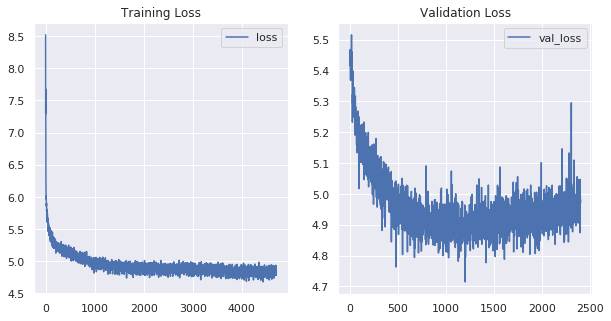


Training Duration = 0:16:50.799446


In [48]:
hyperparams = Hyperparams(vocab_size=5000, embed_size=256, hidden_size=256, num_layers=2,
                          dropout=0.5, recurrent_dropout=0,
                          loss_func=nn.CrossEntropyLoss,
                          learning_rate=0.03, optimizer=optim.Adam, batch_size=128)

traindataloader, valdataloader, model, optimizer, criterion = initialize_data_model_optim_loss(hyperparams)

t1 = datetime.datetime.now()
train_to_epoch = 100
history = train(train_to_epoch, traindataloader, valdataloader, model, criterion, optimizer)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

histories.append(history)

In [49]:
with open(os.path.join('models', 'model1-histories-epch' + str(train_to_epoch) + '.pkl'), 'wb') as outfile:
    pickle.dump(histories, outfile)

In [54]:
train_loss = []
val_loss = []
for h in histories:
    for a_loss in h['loss']:
        train_loss.append(a_loss)
    for a_loss in h['val_loss']:
        val_loss.append(a_loss)

print('Min Validation Loss = {} @ mini-batch {}\nMin Train Loss = {}'.format(
    min(val_loss),
    val_loss.index(min(val_loss)),
    train_loss[-1]))
    

Min Validation Loss = 4.714593887329102 @ mini-batch 1199
Min Train Loss = 4.776748180389404


## Results

### Load best model

In [48]:
hyperparams = Hyperparams(vocab_size=5000, embed_size=256, hidden_size=256, num_layers=2,
                          dropout=0.5, recurrent_dropout=0,
                          loss_func=nn.CrossEntropyLoss,
                          learning_rate=0.03, optimizer=optim.Adam, batch_size=128)

traindataloader, valdataloader, model, optimizer, criterion = initialize_data_model_optim_loss(hyperparams)

In [49]:
model.load_state_dict(torch.load(os.path.join('models', 'model1.best.1199.pth')))

In [50]:
# Calculate perplexity
criterion = nn.CrossEntropyLoss(ignore_index=books_data_train.vocab.token2id['<pad>'],
                                reduction='mean')
val_losses = []
model.train(False)
for batch in tqdm(valdataloader):
    # Zero gradient.
    optimizer.zero_grad()
    x = batch['x'].to(device)
    x_len = batch['x_len'].to(device)
    y = batch['y'].to(device)
    # Feed forward.
    with torch.no_grad():
      output, hidden = model(x, use_softmax=False)
      # Compute loss:
      # Shape of the `output` is [batch_size x sequence_len x vocab_size]
      # Shape of `y` is [batch_size x sequence_len]
      # CrossEntropyLoss expects `output` to be [batch_size x vocab_size x sequence_len]
      # _, prediction = torch.max(output, dim=2)
      val_loss = criterion(output.permute(0, 2, 1), y)
      # val_loss.backward()
      # optimizer.step()
      val_losses.append(val_loss.float().data)

perplexity = math.exp(sum(val_losses) / len(valdataloader))
perplexity

100%|██████████| 24/24 [00:01<00:00, 20.40it/s]


133.02597561396001

In [51]:
for _ in range(10):
    generate_example(model)

<s> i are for <unk> <unk> bit <unk> as him <unk> her suggesting to whom me had <unk> distance where i ’ now he would suppose the avenue care <unk> and expected quite place <unk> or <unk> for the <unk> <unk> sleeping <unk> no used no ’ s postern <unk> too to not than making joe <unk> without probably let purpose very as <unk> attend to be added at in conversation <unk> <unk> sir first <unk> for the back <unk> where he had and as once <unk> for me lie on <unk> in an going it <unk> <unk> as his <unk>
<s> pint of air <unk> <unk> the echoes <unk> without this <unk> came . </s>
<s> what i ’ d as any <unk> possessing of that mr. jasper. <unk> ’ ’ edwin <unk> you see him mr. so <unk> i do it as if i stood she was gone that this <unk> <unk> who as his sharp <unk> he <unk> evidently that before . </s>
<s> i was so <unk> down <unk> <unk> with another of the one : ’ two . </s>
<s> do we hoped fast <unk> the easy-chair come back to my i my little is other <unk> for goes <unk> <unk> other <unk> at “

In [53]:
# torch.save(model.state_dict(), os.path.join('models', 'gru-model1.pth'))

hyperparams = Hyperparams(vocab_size=5000, embed_size=256, hidden_size=256, num_layers=2,
                          dropout=0.5, recurrent_dropout=0,
                          loss_func='nn.CrossEntropyLoss',
                          learning_rate=0.03, optimizer='optim.Adam', batch_size=128)
with open(os.path.join('models', 'model1.json'), 'w') as fout:
    json.dump(dict(hyperparams._asdict()), fout)